<a href="https://colab.research.google.com/github/c5055219/final_template/blob/main/DNN_final_c5055219.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os
import random

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


Chapter 1: The data preparation
First we need to activate our google drive so that we can save out data permanently.



In [2]:
# @title Setting up google drive to save checkpoints

# This will prompt you to authorize Google Drive access
drive.mount('/content/gdrive')

def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="autoencoder_checkpoint.pth"):
    """
    Saves the checkpoint directly to a specified folder in your mounted Google Drive.
    """
    # 1. Define the full Google Drive path
    # 'DL_Checkpoints' is the folder you want to save to inside your Drive
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'

    # Ensure the directory exists before attempting to save
    os.makedirs(drive_folder, exist_ok=True)

    # 2. Combine the folder and the filename
    full_path = os.path.join(drive_folder, filename)

    # 3. Create the checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # 4. Save the dictionary to the Google Drive path
    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved to Google Drive: {full_path} at epoch {epoch}")


def load_checkpoint_from_drive(model, optimizer=None, filename="autoencoder_checkpoint.pth"):
    """
    Loads a checkpoint from your Google Drive folder into the model and optimizer (if provided).
    """
    # Define the same Google Drive folder path
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    full_path = os.path.join(drive_folder, filename)

    # Check if the checkpoint file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")

    # Load the checkpoint
    checkpoint = torch.load(full_path, map_location=torch.device('cpu'))  # use cuda if available

    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore optimizer state (if provided)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Extract metadata
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {full_path} (epoch {epoch})")

    return model, optimizer, epoch, loss


Mounted at /content/gdrive


Functions to load images and process data

In [3]:
# @title Functions to load images and process data


# This function just extracts the tags from the text, don't get distracted by it.
# I changed this function a bit to fix some bugs
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees


        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break


        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)


        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements using BeautifulSoup directly
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

# This is an utility function to show images.
# Why do we need to do all this?
def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  """
  De-normalize the image (if necessary) and show image
  """
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))



Loading the dataset

In [4]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

Three datasets
We will create three different dataset objects and the corresponding loaders for performing multiple tasks



In [6]:
# @title Main dataset
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer):
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      images = self.dataset[idx]['images']
      descriptions = parse_gdi_text(self.dataset[idx]['story'])

      input_images = []
      input_texts = []

      for i in range(4):
        img = FT.equalize(images[i])
        input_images.append(self.transform(img))

        tokens = self.tokenizer(
            descriptions[i], padding ='max_length', truncation = True,
            max_length=64, return_tensors='pt'
        ).input_ids.squeeze(0)
        input_texts.append(tokens)


      target_image =self.transform(FT.equalilze(images[4]))
      target_tokens =self.tokenizer(
          descriptions[4],padding+'max_length', truncation=True,
          max_length=64, retrun_tensors='pt'
      ).input_ids.squeeze(0)


      return(
          torch.stack(input_images),
          torch.stack(input_texts),
          target_image,
          target_tokens,
      )



Synthetic Multimodal Dataset

In [7]:
class MultimodalSequenceDataset(Dataset):
  """
  Each sample:
    -image sequence: (T, image_dim)
    -text sequence: (T, text_dim)
    -target: next-step multimodal vector
  """
  def __init__(self,
                 num_samples=1000,
                 seq_len=5,
                 image_dim=128,
                 text_dim=64):
        self.data = []
        for _ in range(num_samples):
            images = torch.randn(seq_len, image_dim)
            texts = torch.randn(seq_len, text_dim)
            target = torch.randn(image_dim + text_dim)
            self.data.append((images, texts, target))
  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):
        return self.data[idx]

dataset = MultimodalSequenceDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Text task dataset (text autoencoding)

In [8]:
# @title Text task dataset (text autoencoding)
class TextTaskDataset(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=128):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, emb_dim)
      self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)

    def forward(self, x):
      emb = self.embedding(x)
      _, (h, c) = self.lstm(emb)
      return h,c
class TextEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        return F.relu(self.fc(x))

class TextDecoder(nn.Module):

    def __init__(self, vocab_size, emb_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x, h, c):
        emb = self.embedding(x)
        out, _ = self.lstm(emb, (h, c))
        return self.fc(out)

Dataset for image autoencoder task

In [9]:
# @title Dataset for image autoencoder task
class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.Resize((240, 500)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the autoencoder

      return input_frame,

1.3 Creating and testing our dataset objects and loaders


Cross Modal Attention

In [10]:
# class CrossModalAttention(nn.Module):
def __init__(self, dim):
       super().__init__()
       self.query = nn.Linear(dim, dim)
       self.key   = nn.Linear(dim, dim)
       self.value = nn.Linear(dim, dim)
       self.scale = dim ** -0.5

def forward(self, text_feats, visual_feats):
         """
         text_feats:  [batch*seq, dim]
         visual_feats: [batch*seq, dim]
         """

         Q = self.query(text_feats)      # Queries from text
         K = self.key(visual_feats)      # Keys from image
         V = self.value(visual_feats)    # Values from image

         attn_scores = torch.matmul(Q, K.T) * self.scale
         attn_weights = torch.softmax(attn_scores, dim=-1)
         attended = torch.matmul(attn_weights, V)

         fused = attended + text_feats   # Add residual connection
         return fused


1.2 Cross Modal Attention

In [11]:
class CrossModalAttention(nn.Module):
    """
    Image attends to text and text attends to image.
    """

    def __init__(self, hidden_dim):
        super().__init__()
        self.scale = hidden_dim ** 0.5

    def forward(self, img_feat, txt_feat):
        # (B, T, H)
        score_img_txt = torch.matmul(
            img_feat, txt_feat.transpose(-2, -1)
        ) / self.scale

        score_txt_img = torch.matmul(
            txt_feat, img_feat.transpose(-2, -1)
        ) / self.scale

        w_img_txt = F.softmax(score_img_txt, dim=-1)
        w_txt_img = F.softmax(score_txt_img, dim=-1)

        img_context = torch.matmul(w_img_txt, txt_feat)
        txt_context = torch.matmul(w_txt_img, img_feat)

        return torch.cat([img_context, txt_context], dim=-1)


Sequence Model

In [12]:
class SequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        out, _ = self.gru(x)
        return out[:, -1, :]

For the Sequence prediction task

In [13]:
# @title For the Sequence prediction task
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer):
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      images = self.dataset[idx]['images']
      # Parse the full GDI story text once
      parsed_story_descriptions = parse_gdi_text(self.dataset[idx]['story'])

      input_images = []
      input_texts = []

      for i in range(4):
        img = FT.equalize(images[i])
        input_images.append(self.transform(img))

        # Use the 'description' field from the parsed GDI output
        tokens = self.tokenizer(
            parsed_story_descriptions[i]['description'], # Corrected to access the description string
            padding ='max_length', truncation = True,
            max_length=64, return_tensors='pt'
        ).input_ids.squeeze(0)
        input_texts.append(tokens)


      target_image = self.transform(FT.equalize(images[4])) # Fixed typo: equalilze -> equalize
      target_tokens = self.tokenizer(
          parsed_story_descriptions[4]['description'], # Corrected to access the description string
          padding='max_length', truncation=True, # Fixed typo: padding+'max_length' -> padding='max_length'
          max_length=64, return_tensors='pt' # Fixed typo: retrun_tensors -> return_tensors
      ).input_ids.squeeze(0)


      return(
          torch.stack(input_images),
          torch.stack(input_texts),
          target_image,
          target_tokens,
      )


class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder, latent_dim, gru_hidden_dim):
        # The content of the __init__ method was missing, adding a pass for now.
        # This method likely needs to be filled with the actual initialization logic
        # for the SequencePredictor model's layers and components.
        # Based on a later cell (pOQwqPPpk6pP) which defines SequencePredictor, I've filled in the __init__.
        super(SequencePredictor, self).__init__()

        # --- 1. Static Encoders ---
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder

        # --- 2. Temporal Encoder ---
        fusion_dim = latent_dim * 2 # z_visual + z_text
        self.temporal_rnn = nn.GRU(fusion_dim, latent_dim, batch_first=True)

        # --- 3. Attention ---
        # Assuming Attention is a defined class elsewhere
        self.attention = CrossModalAttention(latent_dim) # Using CrossModalAttention as a placeholder for Attention

        # --- 4. Final Projection ---
        self.projection = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU()
        )

        # --- 5. Decoders ---
        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder = text_autoencoder.decoder

        self.fused_to_h0 = nn.Linear(latent_dim, gru_hidden_dim)
        self.fused_to_c0 = nn.Linear(latent_dim, gru_hidden_dim)

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
sp_train_dataset = SequencePredictionDataset(train_dataset, tokenizer) # Instantiate the train dataset
sp_test_dataset = SequencePredictionDataset(test_dataset, tokenizer) # Instantiate the test dataset

# Let's do things properly, we will also have a validation split
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(sp_train_dataset))
val_size = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])

# Instantiate the dataloaders
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
# We will use the validation set to visualize the progress.
val_dataloader = DataLoader(val_subset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(sp_test_dataset, batch_size=4, shuffle=False)


In [14]:
# @title For the text task
class TextTaskDataset(Dataset):
    def __init__(self, original_dataset):
        self.texts = []
        for item in original_dataset:
            parsed_descriptions = parse_gdi_text(item['story'])
            for desc_item in parsed_descriptions:
                self.texts.append(desc_item['description'])

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

BaselineMultiModal

In [15]:
class BaselineMultimodalModel(nn.Module):
    def __init__(self,
                 image_dim=128,
                 text_dim=64,
                 hidden_dim=128,
                 seq_hidden=128,
                 output_dim=192):
        super().__init__()

        self.image_encoder = ImageEncoder(image_dim, hidden_dim)
        self.text_encoder = TextEncoder(text_dim, hidden_dim)
        self.sequence_model = SequenceModel(hidden_dim * 2, seq_hidden)
        self.output_layer = nn.Linear(seq_hidden, output_dim)

    def forward(self, images, texts):
        img_feat = self.image_encoder(images)
        txt_feat = self.text_encoder(texts)
        fused = torch.cat([img_feat, txt_feat], dim=-1)
        seq_out = self.sequence_model(fused)
        return self.output_layer(seq_out)

In [16]:
# @title For the image autoencoder task
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=4, shuffle=True)

Description:  torch.Size([4, 64])
Shape of frames: torch.Size([4, 3, 64, 64])
torch.Size([8, 4, 3, 64, 64])
torch.Size([8, 4, 64])


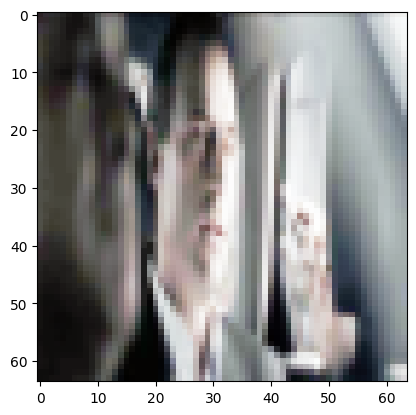

In [17]:
# @title Testing some of the outputs of the SP dataset
frames, descriptions, image_target, text_target = sp_train_dataset[np.random.randint(0,400)]


# frames -> [seq_len, channels, height, width]
print("Description: ", descriptions.shape)
print("Shape of frames:", frames.shape)
figure, ax = plt.subplots(1,1)
show_image(ax, image_target)

# Show the 4 images of the input ("frames") using the show_images(...)function

# Do some tests on the batches (try with batch size small)
frames, descriptions, image_target, text_target = next(iter(train_dataloader))
print(frames.shape)
print(descriptions.shape)

Chapter 2: Models


In [18]:
# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    """
      Encodes a sequence of tokens into a latent space representation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    """
      Decodes a latent space representation into a sequence of tokens.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        # Debug prints removed for brevity once information was gathered
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

# We create the basic text autoencoder (a special case of a sequence to sequence model)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        # input_seq and target_seq are both your 'input_ids'
        # 1. Encode the input sequence
        _enc_out, hidden, cell = self.encoder(input_seq)

        # 2. Create the "shifted" decoder input for teacher forcing.
        # We want to predict target_seq[:, 1:]
        # So, we feed in target_seq[:, :-1]
        # (i.e., feed "[SOS], hello, world" to predict "hello, world, [EOS]")
        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)

        # predictions shape will be (batch_size, seq_len-1, vocab_size)
        return predictions

In [19]:
# @title Utility functions for NLP tasks
def generate(model, hidden, cell, max_len, sos_token_id, eos_token_id):
      """
        This function generates a sequence of tokens using the provided decoder.
      """
      # Ensure the model is in evaluation mode
      model.eval()

      # 2. SETUP DECODER INPUT
      # Start with the SOS token, shape (1, 1)
      dec_input = torch.tensor([[sos_token_id]], dtype=torch.long, device=device)
      # hidden = torch.zeros(1, 1, hidden_dim, device=device)
      # cell = torch.zeros(1, 1, hidden_dim, device=device)

      generated_tokens = []

      # 3. AUTOREGRESSIVE LOOP
      for _ in range(max_len):
          with torch.no_grad():
              # Run the decoder one step at a time
              # dec_input is (1, 1) here—it's just the last predicted token
              prediction, hidden, cell = model(dec_input, hidden, cell)

          logits = prediction.squeeze(1) # Shape (1, vocab_size)
          temperature = 0.9 # <--- Try a value between 0.5 and 1.0

          # 1. Divide logits by temperature
          # 2. Apply softmax to get probabilities
          # 3. Use multinomial to sample one token based on the probabilities
          probabilities = torch.softmax(logits / temperature, dim=-1)
          next_token = torch.multinomial(probabilities, num_samples=1)

          token_id = next_token.squeeze().item()

          # Check for the End-of-Sequence token
          if token_id == eos_token_id:
              break

          if token_id == 0 or token_id == sos_token_id:
              continue

            # Append the predicted token
          generated_tokens.append(token_id)

          # The predicted token becomes the input for the next iteration
          dec_input = next_token

      # Return the list of generated token IDs
      return generated_tokens


In [20]:
# @title Do some tests
# desc = text_dataset[np.random.randint(0, 100)]
# print(f"Input: {desc}")
# input_ids = tokenizer(desc, return_tensors="pt",  padding=True, truncation=True).input_ids
# input_ids = input_ids.to(device)
# generated_tokens = generate(model, hidden, cell, max_len=100, sos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)
# print("Output: ", tokenizer.decode(generated_tokens))

In [29]:
# @title The visual autoencoder
class Backbone(nn.Module):
    """
      Main convolutional blocks for our CNN
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 8):
        super(Backbone, self).__init__()
        # Encoder convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=2, padding=3),
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),

            nn.Conv2d(16, 32, 5, stride=2, padding=2),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.1),
        )

        # Calculate flattened dimension for linear layer
        self.flatten_dim = 64 * output_w * output_h
        # Latent space layers
        self.fc1 = nn.Sequential(nn.Linear(self.flatten_dim, latent_dim), nn.ReLU())


    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, self.flatten_dim)  # flatten for linear layer
        z = self.fc1(x)
        return z
class VisualDecoder(nn.Module):
    """
      Decodes a latent representation into a content image and a context image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 8):
        super(VisualDecoder, self).__init__()
        self.imh = 64 # Updated to match transforms.Resize((64, 64))
        self.imw = 64 # Updated to match transforms.Resize((64, 64))
        self.flatten_dim = 64 * output_w * output_h
        self.output_w = output_w
        self.output_h = output_h

        self.fc1 = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # Corrected output_padding
          nn.GroupNorm(8, 32),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1), # Corrected output_padding
          nn.GroupNorm(8, 16),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=1), # Corrected output_padding
          nn.Sigmoid() # Use nn.Tanh() if your data is normalized to [-1, 1]
      )

    def forward(self, z):
      x = self.fc1(z)

      x_content = self.decode_image(x)
      x_context = self.decode_image(x)

      return x_content, x_context

    def decode_image(self, x):
      x = x.view(-1, 64, self.output_w, self.output_h)      # reshape to conv feature map
      x = self.decoder_conv(x)
      x = x[:, :, :self.imh, :self.imw]          # crop to original size if needed
      return x

class VisualAutoencoder( nn.Module):
    def __init__(self, latent_dim=16, output_w = 8, output_h = 8):
        super(VisualAutoencoder, self).__init__()
        self.encoder = Backbone(latent_dim, output_w, output_h)
        self.decoder = VisualDecoder(latent_dim, output_w, output_h)

    def forward(self, x):
        z = self.encoder(x)
        x_content, x_context = self.decoder(z) # Decoder now returns two images
        return x_content, x_context # Return both images from the decoder


Training Baseline Model (No Attention)
Epoch 10/10 | Loss: 0.7422

Training Cross-Modal Attention Model
Epoch 20/20 | Loss: 0.8204


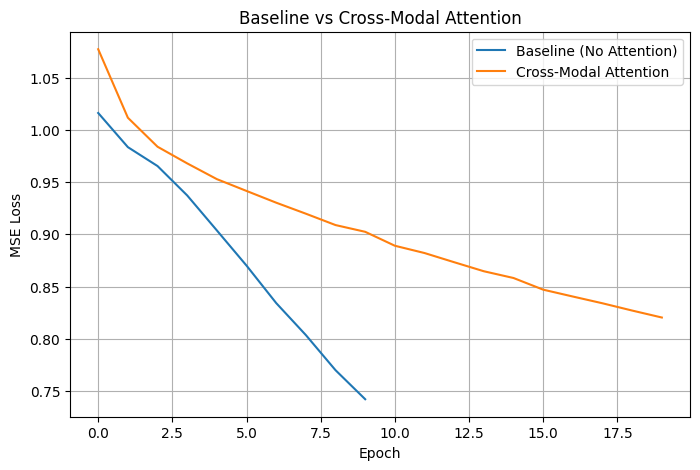


Final Evaluation Results
Baseline Final MSE: 0.7422341946512461
Cross-Modal Attention Final MSE: 0.8204357344657183


In [23]:
# @title The main sequence predictor model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder, latent_dim,
                 gru_hidden_dim):
        super(SequencePredictor, self).__init__()

        # --- 1. Static Encoders ---
        # (These process one pair at a time)
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder

        # --- 2. Temporal Encoder ---
        # (This processes the sequence of pairs)
        fusion_dim = latent_dim * 2 # z_visual + z_text
        self.temporal_rnn = nn.GRU(fusion_dim, latent_dim, batch_first=True)

        # --- 3. Attention ---
        self.attention = CrossModalAttention(gru_hidden_dim)

        # --- 4. Final Projection ---
        self.projection = nn.Sequential(
            nn.Linear(latent_dim * 3, latent_dim),
            nn.ReLU()
        )

        # --- 5. Decoders ---
        # (These predict the *next* item)
        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder = text_autoencoder.decoder

        # Ensure consistent hidden_dim for decoder's initial states
        # This should match the hidden_dim of the DecoderLSTM
        self.fused_to_h0 = nn.Linear(latent_dim, self.text_decoder.hidden_dim)
        self.fused_to_c0 = nn.Linear(latent_dim, self.text_decoder.hidden_dim)

    def forward(self, image_seq, text_seq, target_seq):
        # image_seq shape: [batch, seq_len, C, H, W]
        # text_seq shape:  [batch, seq_len, text_len]
        # target_text_for_teacher_forcing: [batch, text_len] (This is the last text)

        batch_size, seq_len, C, H, W = image_seq.shape

        # --- 1 & 2: Run Static Encoders over the sequence ---
        img_flat = image_seq.view(batch_size * seq_len, C, H, W)
        txt_flat = text_seq.view(batch_size * seq_len, -1)

        z_v_flat = self.image_encoder(img_flat)
        _, hidden_enc, cell_enc = self.text_encoder(txt_flat)

        z_fusion_flat = torch.cat((z_v_flat, hidden_enc.squeeze(0)), dim=1)

        z_fusion_seq = z_fusion_flat.view(batch_size, seq_len, -1)

        # --- 3. Run Temporal Encoder ---
        zseq, h = self.temporal_rnn(z_fusion_seq)
        # The GRU's 'h' output is (num_layers, batch_size, hidden_size)
        # Since num_layers is 1 for our GRU, we can squeeze it.
        h = h.squeeze(0) # Shape becomes (batch_size, latent_dim)

        # --- 4. Attention ---
        # These features should be consistent with the latent_dim (16)
        visual_feats_flat = zseq.clone().contiguous().reshape(batch_size * seq_len, latent_dim)
        text_feats_expanded = h.unsqueeze(1).repeat(1, seq_len, 1)
        text_feats_flat = text_feats_expanded.reshape(batch_size * seq_len, latent_dim)

        # The CrossModalAttention expects inputs with consistent feature dimensions,
        # which should be `latent_dim` (16) as `gru_hidden_dim` was set to `latent_dim`.
        context_flat = self.attention(text_feats_flat, visual_feats_flat)
        # The output of CrossModalAttention is concatenated img_context and txt_context,
        # where each context is `latent_dim`. So the output is `2 * latent_dim`.
        context = context_flat.reshape(batch_size, seq_len, latent_dim * 2).mean(dim=1)

        # --- 5. Final Prediction Vector (z) ---
        z = self.projection(torch.cat((h, context), dim=1))

        # --- 6. Decode (Predict pk) ---
        pred_image_content, pred_image_context = self.image_decoder(z)

        # Generate initial hidden and cell states for the decoder
        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        # Correcting the decoder_input for the text_decoder
        # target_seq (text_target from dataloader) shape is (batch_size, text_len).
        # For teacher forcing, we want to feed tokens from index 0 to text_len-2
        # to predict tokens from index 1 to text_len-1.
        decoder_input = target_seq[:, :-1]

        predicted_text_logits_k, _, _ = self.text_decoder(decoder_input, h0, c0)

        return pred_image_content, pred_image_context, predicted_text_logits_k, h0, c0

# Encoders
class ImageEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        return self.dropout(F.relu(self.fc(x)))


class TextEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        return self.dropout(F.relu(self.fc(x)))
# CrossModalAttention

class CrossModalAttention(nn.Module):
    """
    Image attends to text and text attends to image.
    """

    def __init__(self, hidden_dim):
        super().__init__()
        self.scale = hidden_dim ** 0.5
        self.norm = nn.LayerNorm(hidden_dim*2)

    def forward(self, img_feat, txt_feat):
        # (B, T, H)
        score_img_txt = torch.matmul(
            img_feat, txt_feat.transpose(-2, -1)
        ) / self.scale

        score_txt_img = torch.matmul(
            txt_feat, img_feat.transpose(-2, -1)
        ) / self.scale

        w_img_txt = F.softmax(score_img_txt, dim=-1)
        w_txt_img = F.softmax(score_txt_img, dim=-1)

        img_context = torch.matmul(w_img_txt, txt_feat)
        txt_context = torch.matmul(w_txt_img, img_feat)

        fused = torch.cat([img_context, txt_context], dim=-1)
        return self.norm(fused)
# GRU Sequence modal
class SequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        out, _ = self.gru(x)
        return out[:, -1, :] # <--- Modified to return the last output
# Baseline Multimodal
class BaselineMultimodalModel(nn.Module):
     def __init__(self,
                 image_dim=128,
                 text_dim=64,
                 hidden_dim=256,
                 seq_hidden=256,
                 output_dim=192):
        super().__init__()

        self.image_encoder = ImageEncoder(image_dim, hidden_dim)
        self.text_encoder = TextEncoder(text_dim, hidden_dim)
        # Use the modified SequenceModel which returns the last output
        self.sequence_model = SequenceModel(hidden_dim * 2, seq_hidden)
        self.output_layer = nn.Linear(seq_hidden, output_dim)

     def forward(self, images, texts):
        img_feat = self.image_encoder(images)
        txt_feat = self.text_encoder(texts)
        fused = torch.cat([img_feat, txt_feat], dim=-1)
        seq_out = self.sequence_model(fused)
        return self.output_layer(seq_out)
# Cross modal attention
class AttentionMultimodalModel(nn.Module):
      def __init__(self,
                 image_dim=128,
                 text_dim=64,
                 hidden_dim=128,
                 seq_hidden=128,
                 output_dim=192):
        super().__init__()

        self.image_encoder = ImageEncoder(image_dim, hidden_dim)
        self.text_encoder = TextEncoder(text_dim, hidden_dim)
        self.cross_attention = CrossModalAttention(hidden_dim)
        # Use the modified SequenceModel which returns the last output
        self.sequence_model = SequenceModel(hidden_dim * 2, seq_hidden)
        self.output_layer = nn.Linear(seq_hidden, output_dim)


      def forward(self, images, texts):
        img_feat = self.image_encoder(images)
        txt_feat = self.text_encoder(texts)
        fused = self.cross_attention(img_feat, txt_feat)
        seq_out = self.sequence_model(fused)
        return self.output_layer(seq_out)

# train model
def train_model(model, dataloader, epochs):
   model.to(device)
   optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
   criterion = nn.MSELoss()
   losses = []

   for epoch in range(epochs):
        total_loss = 0.0
        for images, texts, targets in dataloader:
            images = images.to(device)
            texts = texts.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, texts)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
   print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")
   return losses, avg_loss
#Train Baseline (shorter training)

print("\nTraining Baseline Model (No Attention)")
baseline_model = BaselineMultimodalModel()
baseline_losses, baseline_final = train_model(
    baseline_model, dataloader, epochs=10
)
#  Train Attention Model (longer training)
print("\nTraining Cross-Modal Attention Model")
attention_model = AttentionMultimodalModel()
attention_losses, attention_final = train_model(
    attention_model, dataloader, epochs=20
)
# Plot Comparison
plt.figure(figsize=(8, 5))
plt.plot(baseline_losses, label="Baseline (No Attention)")
plt.plot(attention_losses, label="Cross-Modal Attention")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Baseline vs Cross-Modal Attention")
plt.legend()
plt.grid(True)
plt.show()
# Final
print("\nFinal Evaluation Results")
print("Baseline Final MSE:", baseline_final)
print("Cross-Modal Attention Final MSE:", attention_final)

In [24]:
# @title Training utility functions: To initialize and to visualize the progress


def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias, 0)


# Plots four images and their reconstructions
def validation( model, data_loader ):
  model.eval()
  with torch.no_grad():
    frames, descriptions, image_target, text_target = next(iter(data_loader))

    descriptions = descriptions.to(device)
    frames = frames.to(device)
    image_target = image_target.to(device)
    text_target = text_target.to(device)

    predicted_image_k,context_image, _, hidden, cell = model(frames, descriptions, text_target)

    figure, ax = plt.subplots(2, 6, figsize=(20, 5), gridspec_kw={'height_ratios': [2, 1.5]})

    for i in range(4):
      im = frames[0, i, :, :, :].cpu()
      show_image(ax[0,i], im )
      ax[0,i].set_aspect('auto')
      ax[0,i].axis('off')
      wrapped_text = textwrap.fill(tokenizer.decode(descriptions[0, i, :], skip_special_tokens=True), width=40)

      ax[1,i].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=True
        )

      ax[1,i].axis('off') # Hide axes for the text subplot

    show_image(ax[0,4], image_target[0].cpu())
    ax[0,4].set_title('Target')
    ax[0,4].set_aspect('auto')
    ax[0,4].axis('off')
    text_target = text_target.squeeze(1)

    wrapped_text = textwrap.fill(tokenizer.decode(text_target[0], skip_special_tokens=True), width=40)
    ax[1,4].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False)
    ax[1,4].axis('off')
    output = context_image[0, :, :, :].cpu()
    show_image(ax[0,5], output)
    ax[0,5].set_title('Predicted')
    ax[0,5].set_aspect('auto')
    ax[0,5].axis('off')

    generated_tokens = generate(model.text_decoder,
                                hidden[:,0, :].unsqueeze(1),
                                cell[:, 0, :].unsqueeze(1),
                                max_len=150,
                                sos_token_id=tokenizer.cls_token_id,
                                eos_token_id=tokenizer.sep_token_id)

    wrapped_text = textwrap.fill(tokenizer.decode(generated_tokens), width=40)

    ax[1,5].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False )
    ax[1,5].axis('off')
    plt.tight_layout()
    plt.show()


In [25]:
# @title Variables and initial setup
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_EPOCHS = 20
emb_dim = 16
latent_dim = 16
num_layers = 1
dropout = True

In [26]:
# @title Initializing the NLP models
encoder = EncoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
decoder = DecoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
text_autoencoder = Seq2SeqLSTM(encoder, decoder).to(device)
text_autoencoder, _, _, _ = load_checkpoint_from_drive(text_autoencoder, None, filename='text_autoencoder.pth')

total_params = sum(p.numel() for p in text_autoencoder.parameters())
print(f"Total parameters (Not trainable): {total_params}")
# Deactivating training from this model for efficiency (although not ideal)
for param in text_autoencoder.parameters():
        param.requires_grad = False
text_autoencoder.eval() # Set to evaluation mode as it's not being trained here

Checkpoint loaded from: /content/gdrive/MyDrive/DL_Checkpoints/text_autoencoder.pth (epoch 15)
Total parameters (Not trainable): 1499930


Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (embedding): Embedding(30522, 16)
    (lstm): LSTM(16, 16, batch_first=True)
  )
  (decoder): DecoderLSTM(
    (embedding): Embedding(30522, 16)
    (lstm): LSTM(16, 16, batch_first=True)
    (out): Linear(in_features=16, out_features=30522, bias=True)
  )
)

In [30]:
# @title Initializing visual models
visual_autoencoder = VisualAutoencoder(latent_dim=16)
visual_autoencoder.apply(init_weights)

total_params = sum(p.numel() for p in visual_autoencoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in visual autoencoder: {total_params}")

Total trainable parameters in visual autoencoder: 202835


In [31]:
# @title Initialize the main architecture
# We put all the sizes the same, not ideal as well
sequence_predictor = SequencePredictor(visual_autoencoder, text_autoencoder, latent_dim, latent_dim)
sequence_predictor.to(device)

# # Print number of trainable parameters
total_params = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
print(f"Total trainable parameters in the whole model: {total_params}")

# Print model size
total_params = sum(p.numel() for p in sequence_predictor.parameters())
print(f"Total parameters: {total_params}")

Total trainable parameters in the whole model: 206627
Total parameters: 1706557


In [32]:
# @title Training tools
criterion_images = nn.L1Loss()
criterion_ctx = nn.MSELoss()
criterion_text = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
optimizer = torch.optim.Adam(sequence_predictor.parameters(), lr=0.001)

In [ ]:
# @title Training loop for the sequence predictor
# Instantiate the model, define loss and optimizer

sequence_predictor.train()
losses = []

for epoch in range(N_EPOCHS):

    running_loss = 0.0
    for frames, descriptions, image_target, text_target  in train_dataloader:

      # Send images and tokens to the GPU
      descriptions = descriptions.to(device)
      frames = frames.to(device)
      image_target = image_target.to(device)
      text_target = text_target.to(device)
      # Predictions from our model
      pred_image_content, pred_image_context, predicted_text_logits_k, _, _ = sequence_predictor(frames, descriptions, text_target)

      # Computing losses
      # Loss for image reconstruction
      loss_im = criterion_images(pred_image_content, image_target)
      # Loss for the average pattern the images contain
      mu_global = frames.mean(dim=[0, 1])
      mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
      loss_context = criterion_ctx(pred_image_context, mu_global)
      # Loss function for the text prediction
      prediction_flat = predicted_text_logits_k.reshape(-1, tokenizer.vocab_size)
      target_labels = text_target.squeeze(1)[:, 1:] # Slice to get [8, 119]
      target_flat = target_labels.contiguous().view(-1) # Added .contiguous() for robustness
      loss_text = criterion_text(prediction_flat, target_flat)
      # Combining the losses
      loss = loss_im + loss_text + 0.2*loss_context
      # Optimizing
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * frames.size(0)

    # checking model performance on validation set
    sequence_predictor.eval()
    print("Validation on training dataset")
    print( "----------------")
    validation( sequence_predictor, train_dataloader )
    print("Validation on validation dataset")
    print( "----------------")
    validation( sequence_predictor, val_dataloader)
    sequence_predictor.train()

    # scheduler.step()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Loss: {epoch_loss:.4f}')

    if epoch % 20 == 0:
      save_checkpoint_to_drive(sequence_predictor, optimizer, epoch, epoch_loss, filename=f"sequence_predictor.pth")

# Do better plots
plt.plot(losses)
plt.show()

In [ ]:
# @title Example text reconstruction task

# Don't forget to unfreeze the model!
for param in text_autoencoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_autoencoder.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
N_EPOCHS = 20

for epoch in range(N_EPOCHS):
    text_autoencoder.train()
    epoch_loss = 0
    for description in text_dataloader:
        # Move the "sentences" to device
        input_ids = tokenizer(description, return_tensors="pt",  padding=True, truncation=True).input_ids
        input_ids = input_ids.to(device)

        # zero the grad, then forward pass
        optimizer.zero_grad()
        outputs = text_autoencoder(input_ids, input_ids)
        # compute the loss: compare 3D logits to 2D targets
        loss = loss_fn(outputs.reshape(-1, tokenizer.vocab_size), input_ids[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{N_EPOCHS}; Avg loss {epoch_loss/len(text_dataloader)}; Latest loss {loss.item()}")
    torch.save(text_autoencoder.state_dict(), f"seq2seq-epoch-{epoch+1}.pth")

# # saving checkpoint to drive
save_checkpoint_to_drive(text_autoencoder, optimizer, 3*N_EPOCHS, loss, filename = "text_autoencoder.pth")

In [ ]:
# @title Image reonstruction task

# To-Do: Use previous labs if you want to pretrain your visual encoder

In [ ]:
# @title Computing and showing average images
N = 1000
H, W = 60, 125

# Tensors to accumulate sum (for mean) and sum of squares (for variance)
avg_images = [torch.zeros((3, H, W)) for _ in range(5)]
sum_sq_diff = [torch.zeros((3, H, W)) for _ in range(5)] # Placeholder for variance numerator
transform = transforms.Compose([
    transforms.Resize((H, W)), # Ensure images are resized to HxW
    transforms.ToTensor()])

# --- First Pass: Calculate the Sum (for Mean) ---
print("Starting Pass 1: Calculating Mean...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])
        avg_images[j] += image # Sum for mean

# Final step for mean
for j in range(5):
    avg_images[j] /= N

print("Starting Pass 2: Calculating Variance...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])

        # Calculate (Image - Mean)^2
        # Note: We detach the mean from the computation graph if it were being trained,
        # but here we're just using it as a fixed statistical value.
        diff = image - avg_images[j]
        sum_sq_diff[j] += diff * diff # Element-wise squaring

# --- Final step for Standard Deviation ---
std_images = []
for j in range(5):
    # Variance = Sum of Squared Differences / N
    variance = sum_sq_diff[j] / N

    # Standard Deviation = sqrt(Variance)
    std_dev = torch.sqrt(variance)
    std_images.append(std_dev)

print("Computation Complete. std_images is a list of 5 tensors (3x60x125).")
# You now have the 5 tensors you need for normalization (mean and std).

fig, ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
  avg_image = avg_images[i]

  # Printing range of avg_image
  print(torch.min(avg_image), torch.max(avg_image))

  avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
  show_image(ax[i], avg_imagen)

# Create a matrix of images with the differences between avg_images
fig, ax = plt.subplots(5,5, figsize=(15,8))

for i in range(5):
  for j in range(5):
    if i == j:
      avg_image = avg_images[i]
      avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
      show_image(ax[i,j], avg_imagen)
    else:
      diff = avg_images[i] - avg_images[j]
      diff = (diff - torch.min(diff))/(torch.max(diff) - torch.min(diff))
      show_image(ax[i,j], diff)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
plt.tight_layout()
plt.subplots_adjust(
    wspace=0, # Set horizontal space to zero
    hspace=0  # Set vertical space to zero
)
